Load Data

In [0]:
from skimage.util import view_as_blocks, view_as_windows
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import randint
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, transforms
import time
import os
import copy
import torch
from torch import tensor 
from torch.autograd import Variable
from torch import randn, matmul
import matplotlib.pyplot as plt
from scipy.misc import imresize, bytescale

In [2]:
import tflearn.datasets.oxflower17 as oxflower17
X, Y = oxflower17.load_data(resize_pics=(227, 227))

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
X = np.mean(X, axis=3)

In [0]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {x: torch.utils.data.TensorDataset(torch.tensor(X, dtype=torch.float).unsqueeze_(3).transpose(3,1),torch.tensor(Y, dtype=torch.long))
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

In [0]:
def NC(a):
  
#   return torch.matmul(X,torch.diag(torch.div(1, X.pow(2).sum(dim=0).sqrt())))

  return torch.mm(a, torch.diag(1./(torch.sqrt(torch.sum(a**2, 0))+1e-6)))

In [0]:
def whiten(X):
    '''Function to ZCA whiten image matrix.'''
    U,S,V = torch.svd(torch.mm(X, torch.t(X)))
    epsilon = 1e-5
    ZCAMatrix = torch.mm(U, torch.mm(torch.diag(1.0/torch.sqrt(S + epsilon)),
                                                torch.t(U)))
    return torch.mm(ZCAMatrix, X)

In [0]:
patch_size = 121
num_neurons = 64

In [0]:
def get_batch():

  B = np.array([[y.flatten() for y in x] for x in view_as_windows(X[randint(len(X))], (11,11),step = 11)])

  B = torch.tensor(B.reshape(B.shape[0]*B.shape[1], 11**2)).t()
  
  B = whiten(B- torch.mean(B, 0))
  
  return B
                 

In [0]:
lX = get_batch()

In [10]:
lX.shape

torch.Size([121, 400])

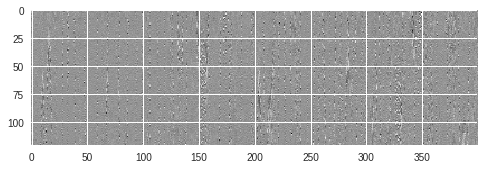

In [11]:
plt.imshow(lX)

In [0]:
W = Variable(randn(patch_size,num_neurons))

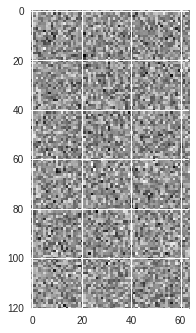

In [13]:
plt.imshow(W)

In [0]:
W = Variable(randn(patch_size,num_neurons))

for i in range(1000):
  
  lX = get_batch()
  
  W = NC(W)
  
  a = torch.matmul(W.t(), lX)
  
  a = NC(a)
  
  a = 0.5*a.pow(3)
  
  W = W + matmul((lX - matmul(W,a)),a.t())
  


In [15]:
W

tensor([[-0.0011, -0.0103, -0.0220,  ...,  0.0719,  0.0007, -0.0092],
        [-0.0389, -0.0036, -0.0138,  ...,  0.0301, -0.0302, -0.0084],
        [-0.0174,  0.0019,  0.0133,  ...,  0.0173,  0.0375,  0.0290],
        ...,
        [ 0.0285,  0.1812,  0.0359,  ...,  0.0115,  0.0101,  0.0166],
        [ 0.0235,  0.0872,  0.0302,  ..., -0.0051, -0.0052, -0.0064],
        [ 0.0370, -0.0041,  0.0127,  ..., -0.0041,  0.0059, -0.0141]])

In [16]:
W.shape

torch.Size([121, 64])

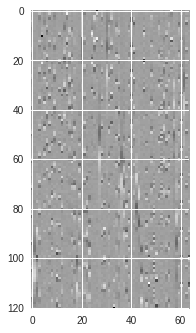

In [17]:
plt.imshow(W)

In [0]:
def montage(X):
    count, m, n = np.shape(X)
    mm = int(np.ceil(np.sqrt(count)))
    nn = mm
    M = np.zeros((mm * m, nn * n))

    image_id = 0
    for j in range(mm):
        for k in range(nn):
            if image_id >= count:
                break
            sliceM, sliceN = j * m, k * n
            M[sliceM:sliceM + m, sliceN:sliceN + n] = bytescale(X[image_id, ...])
            image_id += 1

    return np.uint8(M)

In [0]:
x3out = W.transpose(1,0).view(64,11,11)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: `bytescale` is deprecated!
`bytescale` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
  del sys.path[0]


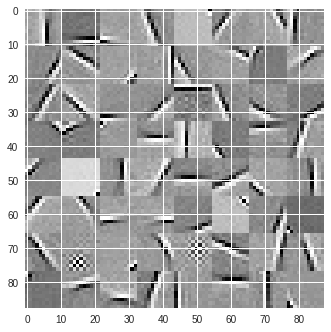

In [20]:
plt.imshow(montage(x3out.numpy()))

Create X^3 Dictionary

Load Dictionary and Initialize Weights

Train Network

In [0]:
class AlexNet(nn.Module):

    def __init__(self):
        super(AlexNet, self).__init__()
        self.initconv = nn.Conv2d(1, 64, kernel_size=11, stride=4, padding=2)
        self.features = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 2048),
            nn.ReLU(inplace=True),
            nn.Linear(2048, 17),
        )

    def forward(self, x):
        x = self.initconv(x)
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), 256 * 6 * 6)
        x = self.classifier(x)
        return x

In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, torch.argmax(labels,1))

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == torch.argmax(labels.data,1))

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


In [0]:
device = torch.device('cuda' if torch.cuda.device_count() > 0 else 'cpu')
net = AlexNet()
net_reg = AlexNet()

In [24]:
net.initconv.weight.data.shape

torch.Size([64, 1, 11, 11])

In [25]:
net.initconv.weight.data = torch.tensor(x3out).unsqueeze_(1).to(torch.float)
net.initconv.weight.requires_grad = False
net = net.to(device)
net_reg = net_reg.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(net.parameters(), lr=0.01, momentum=0.1)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.9)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


In [26]:
net = train_model(net, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=50)

Epoch 0/49
----------
train Loss: 2.8346 Acc: 0.0559
val Loss: 2.8323 Acc: 0.0794

Epoch 1/49
----------
train Loss: 2.8335 Acc: 0.0588
val Loss: 2.8309 Acc: 0.1044

Epoch 2/49
----------
train Loss: 2.8316 Acc: 0.0625
val Loss: 2.8277 Acc: 0.0691

Epoch 3/49
----------
train Loss: 2.8263 Acc: 0.0721
val Loss: 2.8158 Acc: 0.0610

Epoch 4/49
----------
train Loss: 2.8085 Acc: 0.0676
val Loss: 2.7831 Acc: 0.0926

Epoch 5/49
----------
train Loss: 2.7370 Acc: 0.1132
val Loss: 2.6738 Acc: 0.1243

Epoch 6/49
----------
train Loss: 2.5756 Acc: 0.1801
val Loss: 2.5492 Acc: 0.1993

Epoch 7/49
----------
train Loss: 2.3756 Acc: 0.2294
val Loss: 2.1611 Acc: 0.2919

Epoch 8/49
----------
train Loss: 2.2438 Acc: 0.2868
val Loss: 2.1558 Acc: 0.2868

Epoch 9/49
----------
train Loss: 2.1250 Acc: 0.3088
val Loss: 2.1793 Acc: 0.2860

Epoch 10/49
----------
train Loss: 2.0168 Acc: 0.3566
val Loss: 1.8734 Acc: 0.3860

Epoch 11/49
----------
train Loss: 1.8766 Acc: 0.3765
val Loss: 1.6805 Acc: 0.4426

Ep

In [27]:
net_reg = train_model(net_reg, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=50)

Epoch 0/49
----------
train Loss: 2.8333 Acc: 0.0588
val Loss: 2.8333 Acc: 0.0588

Epoch 1/49
----------
train Loss: 2.8333 Acc: 0.0588
val Loss: 2.8333 Acc: 0.0588

Epoch 2/49
----------
train Loss: 2.8333 Acc: 0.0588
val Loss: 2.8333 Acc: 0.0588

Epoch 3/49
----------
train Loss: 2.8333 Acc: 0.0588
val Loss: 2.8333 Acc: 0.0588

Epoch 4/49
----------
train Loss: 2.8333 Acc: 0.0588
val Loss: 2.8333 Acc: 0.0588

Epoch 5/49
----------
train Loss: 2.8333 Acc: 0.0588
val Loss: 2.8333 Acc: 0.0588

Epoch 6/49
----------
train Loss: 2.8333 Acc: 0.0588
val Loss: 2.8333 Acc: 0.0588

Epoch 7/49
----------
train Loss: 2.8333 Acc: 0.0588
val Loss: 2.8333 Acc: 0.0588

Epoch 8/49
----------
train Loss: 2.8333 Acc: 0.0588
val Loss: 2.8333 Acc: 0.0588

Epoch 9/49
----------
train Loss: 2.8333 Acc: 0.0588
val Loss: 2.8333 Acc: 0.0588

Epoch 10/49
----------
train Loss: 2.8333 Acc: 0.0588
val Loss: 2.8333 Acc: 0.0588

Epoch 11/49
----------
train Loss: 2.8333 Acc: 0.0588
val Loss: 2.8333 Acc: 0.0588

Ep

KeyboardInterrupt: ignored